# Asymmetric Uncertainties

A model for asymmetric uncertainties [(Eq 21 in Barlow, 2003)](https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf)

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

In [138]:
def logL(x, mu, sigma_lo, sigma_hi):
    """Log-likelihood for a 1D confidence interval with asymmetric errors.

    Based on eq. 21 from R. Barlow, "Asymmetric Errors," PHYSTAT 2003.

    Parameters
    ----------
    x : float or ndarray
        Value(s) to evaluate the likelihood.
    mu : float
        Maximum likelihood value for the interval.
    sigma_lo : float
        Lower edge of central 68% confidence interval.
    sigma_hi : float
        Upper edge of central 68% confidence interval.

    Returns
    -------
    logL : float or ndarray
        Log likelihood.
    """
    beta = sigma_hi / sigma_lo
    gamma = (sigma_hi*sigma_lo) / (sigma_hi - sigma_lo)
    cut = (x - mu)/gamma > -1
    return -0.5 * (np.log(1. + (x - mu)/gamma, where=cut, out=np.inf*np.ones_like(x)) / np.log(beta))**2

### Log Likelihood

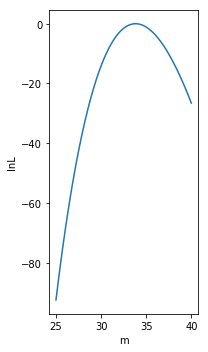

In [139]:
fig, ax = plt.subplots(1, 1, figsize = (3,5))
m = 33.82 # central value, an example
a = np.linspace(25, 40, 1000)
# Negative and Positive uncertainties
sig_pos = 0.78
sig_neg = 0.76

lnL = logL(a, mu=m, sigma_lo=sig_neg, sigma_hi=sig_pos)
#print( lnL)

ax.plot(a, lnL)
ax.set(xlabel = "m", ylabel = "lnL")
fig.tight_layout()

### Probability Distribution Function

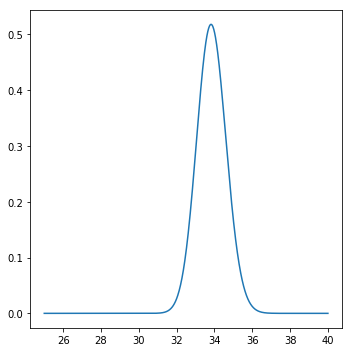

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
L = np.exp(lnL)
L/=np.trapz(L, a)
# print(L)
ax.plot(a, L)
fig.tight_layout()

### Cumulative PDF

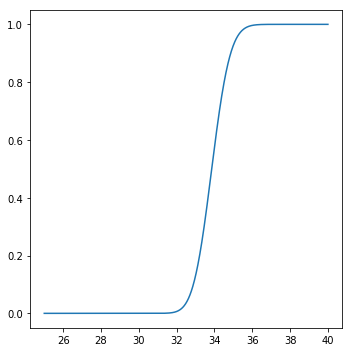

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
cdf = np.zeros_like(a)
for i in range(a.size):
    cdf[i] = np.trapz(L[:i], a[:i])
ax.plot(a, cdf)
fig.tight_layout()

### Random Sampling

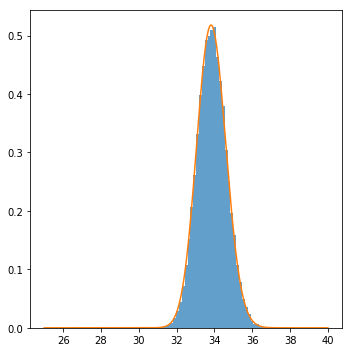

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
cut = cdf > 0 
Cdf = PchipInterpolator(cdf[cut], a[cut])
u = np.random.uniform(0.,1., 50000)
A = Cdf(u)
ax.hist(A, bins=np.linspace(25,40,100), alpha=0.7, density=True)
ax.plot(a, L)
fig.tight_layout()

In [163]:
class ValueCI(object):

    def __init__(self, val, ci_lo, ci_hi):
        """Initialize a value with potentially asymmetric error bars.
        Assume the CI refers to 68% region around the central value.

        Parameters
        ----------
        val : float
            Centra value.
        ci_lo : float
            Lower range of 68% C.I. around central value.
        ci_hi : float
            Upper range of 68% C.I. around central value.
        """
        self.value = val
        self.ci_lo = ci_lo
        self.ci_hi = ci_hi
    
    def likelihood(self, x):
        """Likelihood for a 1D confidence interval with asymmetric errors.

        Based on eq. 21 from R. Barlow, "Asymmetric Errors," PHYSTAT 2003.

        Parameters
        ----------
        x : float or ndarray
            Value(s) to evaluate the likelihood.

        Returns
        -------
        L : float or ndarray
            Likelihood.
        """
        if self.ci_lo == self.ci_hi:
            pass
        else:
            beta = self.ci_hi / self.ci_lo
            gamma = (self.ci_hi*self.ci_lo) / (self.ci_hi - self.ci_lo)
            cut = (x - self.value)/gamma > -1
            return np.exp(-0.5 * (np.log(1. + (x - self.value)/gamma, where=cut, out=np.inf*np.ones_like(x)) / np.log(beta))**2)

    def get_pdf(self, a):
        if self.ci_hi == self.ci_lo:
            pass
        else:
            L = self.likelihood(a)/np.trapz(self.likelihood(a), a)
            return L
    
    def get_cdf(self, a):
        if self.ci_hi == self.ci_lo:
            pass
        else:
            cdf = np.zeros_like(a)
            for i in range(a.size):
                cdf[i] = np.trapz(self.get_pdf(a)[:i], a[:i])
            return cdf
    
    
    def get_random(self, n=1):
        """Randomly sample values from the distribution.
        If the distribution is asymmetric, treat it as a 2-sided Gaussian.

        Parameters
        ----------
        n : int
            Number of random draws.

        Returns
        -------
        Returns n random draws from a symmetric/asymmetric Gaussian about
        the central value.
        """
        if self.ci_lo == self.ci_hi:
            return np.random.normal(loc=self.value, scale=self.ci_lo, size=n)
        else:
#             return np.random.normal(loc=self.value, scale=self.ci_lo, size=n)
            a = np.linspace(self.value - 5*self.ci_lo, self.value + 5*self.ci_hi, n)
            L = self.get_pdf(a)
            cdf = np.zeros_like(a)
            for i in range(n):
                cdf[i] = np.trapz(L[:i], a[:i])
            cut = self.get_cdf(a) > 0 
            Cdf = PchipInterpolator(self.get_cdf(a)[cut], a[cut])
            u = np.random.uniform(0.,1., 50000)
            A = Cdf(u)
#             cut = self.get_cdf(a) > 0 
#             Cdf = PchipInterpolator(self.get_cdf(a)[cut], a[cut])
#             u = np.random.uniform(0.,1., 50000)
            return A
            

In [164]:
# def asym(arr, val, sig_hi, sig_lo):
#     beta = sigma_hi / sigma_lo
#     gamma = (sigma_hi*sigma_lo) / (sigma_hi - sigma_lo)
#     cut = (x - mu)/gamma > -1

In [165]:
# a = ValueCI(20, 3, 2)
# x = np.linspace(0, 50, 100)
# y = a.get_random(2000)
# # print(y)
# # ln = a.get_cdf(x)
# # # ln/=np.trapz(ln, x)
# # # print(ln)
# fig, ax = plt.subplots(1, 1, figsize=(5,5))
# ax.hist(y, bins=x, alpha=0.7, density=True)
# ax.plot(x, a.get_pdf(x))
# # ax.plot(x,y)
# fig.tight_layout()


ValueError: `x` must be strictly increasing or decreasing.